MACD: -27.113985725376324 - -1.8729840602352572 Signal
MACD: -24.171209006257868 - -7.134533362627974 Signal
MACD: -21.91690761039081 - -10.655232498604102 Signal
MACD: -21.36146636141052 - -13.040134123258415 Signal
MACD: -19.70633615767065 - -14.832725987243984 Signal
MACD: -14.84558592972462 - -16.031234134992467 Signal
MACD: -10.698188413150092 - -16.050643820894983 Signal
MACD: -7.121969924206724 - -15.238126738508496 Signal
MACD: -4.926661590659705 - -13.842419570141251 Signal
MACD: -4.955993681151313 - -12.290864116044702 Signal
MACD: -6.189636280464811 - -11.059842060360534 Signal
MACD: -8.735494627809885 - -9.582401860885188 Signal
MACD: -9.582883279910902 - -9.041667227197406 Signal
MACD: -15.457758392120695 - -8.853177864678802 Signal
MACD: -16.58408921610453 - -10.032062269126929 Signal
MACD: -17.8039782069759 - -11.26735248573864 Signal
MACD: -17.276750806437803 - -12.645850779076135 Signal
MACD: -18.074020237496597 - -13.730298167010217 Signal
MACD: -19.107754859613124 - 

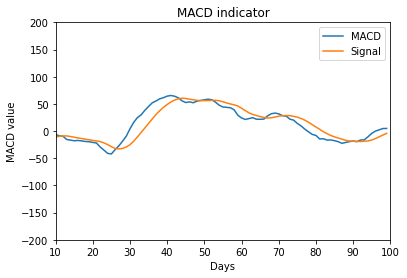

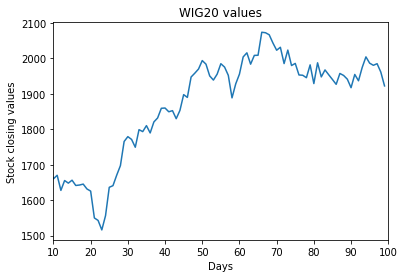

In [13]:
import pandas as pd
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
from pandas import DataFrame


URL = 'https://stooq.pl/q/d/l/?s=wig20&i=d'
SET_SIZE = 100
X_LIMIT = [SET_SIZE // 10, SET_SIZE]
Y_LIMIT = [-200, 200]

# SET_SIZE = 300
# X_LIMIT = [SET_SIZE - 100, SET_SIZE]
# Y_LIMIT = [-200, 200]


def EMA(arr: ndarray, period: int, offset: int) -> float:
    """Returns EMA based on the close value, from last days
    specified by the period variable.
    Offset is counted from the current day.
    """
    a = 2 / (period + 1)
    cur_day = arr.size - offset
    upper_sum = 0.0
    lower_sum = 0.0

    power = 0
    for i in range(cur_day - 1, cur_day - 1 - period - 1, -1):
        upper_sum += arr[i] * (1 - a) ** power
        lower_sum += (1 - a) ** power
        power += 1

    return upper_sum / lower_sum

def get_MACD(df: DataFrame, records: int=SET_SIZE) -> ndarray:
    MACD = []
    values = df.to_numpy()
    values = values[:,4]

    for i in range(records, 0, -1):
        MACD.append(EMA(values, period=12, offset=i) - EMA(values, period=26, offset=i))

    return np.asarray(MACD)

def get_signal(arr: ndarray, records: int=SET_SIZE) -> ndarray:
    signal = []

    for i in range(records, 0, -1):
        signal.append(EMA(arr, period=9, offset=i))

    return np.asarray(signal)

def plot_values(df: DataFrame) -> None:
    x = [i for i in range(SET_SIZE)]
    
    val = df.to_numpy()
    val = val[:, 4]
    
    val = val[val.size - SET_SIZE::]
    
    plt.plot(x, val)
    plt.xlabel('Days')
    plt.ylabel('Stock closing values')
    plt.title('WIG20 values')
    axes = plt.gca()
    axes.set_xlim(X_LIMIT)
    plt.show()

def plot_MACD(df: DataFrame) -> None:
    x = [i for i in range(SET_SIZE)]

    MACD = get_MACD(df)
    signal = get_signal(MACD)
    
    for i in range(MACD.size):
        print(f"MACD: {MACD[i]} - {signal[i]} Signal")

    plt.plot(x, MACD, label='MACD')
    plt.plot(x, signal, label='Signal')
    plt.xlabel('Days')
    plt.ylabel('MACD value')
    plt.legend()
    plt.title('MACD indicator')
    axes = plt.gca()
    axes.set_xlim(X_LIMIT)
    axes.set_ylim(Y_LIMIT)
    plt.show()
    

def main():
    df = pd.read_csv(URL)
    plot_MACD(df)
    plot_values(df)

if __name__ == '__main__':
    main()
